In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using PyTorch version:', torch.__version__, ' device:', device)

Using PyTorch version: 2.6.0+cu126  device: cuda


In [2]:
from typing import Optional, Dict, List, Any

In [3]:
# importam clasa de baza Dataset:
from torch.utils.data import Dataset

In [4]:
# pentru citire de fisier cvs, verificare cai etc:
import pandas as pd
import os
from typing import Tuple

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, path_csv: str):
        """
        Initializeaza setul de date, folosind o cale catre fisier csv
        :param path_csv: cale catre fisier CSV care contine date de train sau test
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte
        super().__init__()
        assert os.path.exists(path_csv) and os.path.isfile(path_csv), f'Calea {path_csv} nu indica spre un fisier'
        self.path_csv = path_csv

        _all_digits = pd.read_csv(path_csv, header=None).values
        
        _y = _all_digits[:, 0]
        _x = _all_digits[:, 1:]
        _x = _x / 255

        self.x = torch.Tensor(_x)
        self.y = torch.Tensor(_y)

    def __len__(self):
        """
        Returneaza lungimea setului de date curent
        :return: lungimea setului de date
        """
        return len(self.y)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returneaza perechea (intrare, eticheta_asociata) de pe pozitia :param index:
        :param index: pozitia de pe care se returneaza vectorul si clasa lui
        :return: pereche: vector de intarre de 784 de elemente, eticheta clasa 0 sau 1
        """
        return self.x[index, :], self.y[index]

In [6]:
train_ds: MNISTDataset = MNISTDataset('./data/mnist_train.csv')
test_ds: MNISTDataset = MNISTDataset('./data/mnist_test.csv')

In [7]:
train_ds[0][0].shape

torch.Size([784])

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def visualize_mnist_samples(dataset: MNISTDataset, num_samples: Optional[int]=10, num_cols: Optional[int]=10):
    """
    Visualize samples from an MNIST dataset

    Args:
        dataset: An instance of MNISTDataset
        num_samples: Number of samples to visualize
    """
    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples // num_cols, num_cols, figsize=(10, 5))

    for i in range(num_samples):
        image, label = dataset[i]
        image: torch.Tensor = image.reshape(28, 28)

        i, j = i // num_cols, i % num_cols

        axes[i][j].imshow(image, cmap='gray')
        axes[i][j].set_title(f"Label: {int(label)}")
        axes[i][j].axis('off')

    plt.tight_layout()
    plt.show()

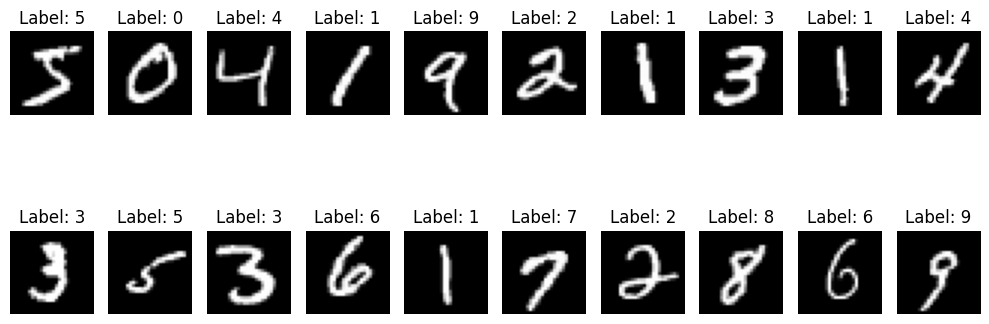

In [10]:
visualize_mnist_samples(train_ds, num_samples=20, num_cols=10)

In [11]:
from torch.utils.data import DataLoader

In [12]:
batch_size: int = 32 # in functie de memoria disponibila pe GPU
train_loader: DataLoader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader: DataLoader = DataLoader(test_ds, batch_size=batch_size)

# pentru primul minibatch tiparim 'shape'
# datele de intrare ar tb sa fie un tensor de forma (batch_size x 784)
# etichetele ar trebui sa fie un tensor de forma batch_size
for data, label in train_loader:
    print(data.shape, label.shape)
    # print(data, label)
    break

torch.Size([32, 784]) torch.Size([32])


In [13]:
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_size: int = 784, num_classes: int = 10):
        """
        Initializarea unui obiect de tip LogisticRegression
        :param input_size: dimensiunea unui vector de intrare. De ex, pt MINST este 784
        """
        # pt clasa derivata se obisnuieste apelul de initializator de clasa parinte
        super().__init__()
        self.input_size: int = input_size
        self.num_classes: int = num_classes
        self.fully_connected: nn.Linear = nn.Linear(input_size, num_classes, bias=True)
        self.dropout: nn.Dropout = nn.Dropout(p=0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Efectueaza propagarea inainte a datelor de intrare x

        Args:
            x (torch.Tensor): valori de intrare

        Returns:
            torch.Tensor: valoarile prezise pentru intrarea
        """
        # x este un minibatch de exemplu de forma 32x784 (ultimul minibatch poate avea mai putin de 32 de tensori)

        # se propaga dinspre stratul de intrare spre primul strat ascuns
        # aplicarea unei functii liniare este echivalenta cu inmulttirea unei matrice cu intrarea curenta
        x: torch.Tensor = self.dropout(x)
        x: torch.Tensor = self.fully_connected(x)

        return x

In [14]:
model = MultinomialLogisticRegression(input_size=784, num_classes=10)
print(model)
summary(model)

MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Layer (type:depth-idx)                   Param #
MultinomialLogisticRegression            --
├─Linear: 1-1                            7,850
├─Dropout: 1-2                           --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0

In [15]:
print(f'device={device}')
model.to(device)

device=cuda


MultinomialLogisticRegression(
  (fully_connected): Linear(in_features=784, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
@torch.no_grad()
def test(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    """
    Testeaza modelul pe datele furnizate de :param loader:
    :param model: model de regresie logistica binara
    :param loader: un dataloader care furnizeaza datele din setul peset care se testeaza
    :param device: pe ce device se afla modelul (cpu, gpu, tpu etc)
    :return: acuratetea de predictie
    """
    # initializare valori pt statistica
    correctly_classified: int = 0
    total_items: int = 0
    # cand se face testarea, modelul nu mai invata. El e trecut explicit in mod de testare
    model.eval()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        
        y_hat: torch.Tensor = model(x).squeeze()
        y_hat_probs: torch.Tensor = torch.softmax(y_hat, dim = 1)
        predicted_class: torch.Tensor = torch.argmax(y_hat_probs, dim=1)
        
        correctly_classified += torch.sum(predicted_class == y)
        total_items += len(x)

    accuracy: float = correctly_classified / total_items
    return accuracy.cpu().detach().item()

In [17]:
acc: float = test(model, train_loader, device)
print(f'Acuratetea modelului neantrenat: {acc * 100}%')

Acuratetea modelului neantrenat: 10.46166643500328%


In [18]:
optimizer: torch.optim.Adam = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
loss_fn: torch.nn.CrossEntropyLoss = torch.nn.CrossEntropyLoss()
epochs: int = 30

In [19]:
def train_fn() -> Tuple[float, float]:
    """Trains the model for one epoch using the provided training data loader.
    
    Processes all batches in the training loader, computes loss, performs 
    backpropagation and optimization steps. Accumulates total loss and count
    of processed items.
    
    Returns:
        Tuple[float, float]: A tuple containing:
            - Total accumulated loss for the epoch
            - Total number of items processed
    """
    
    train_epoch_loss: float = 0
    train_total_items: float = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device).long()
        
        model.zero_grad()
        y_hat: torch.Tensor = torch.squeeze(model(x))
        loss: Any = loss_fn(y_hat, y)
        
        train_epoch_loss += loss.item() * len(x)
        train_total_items += len(x)
        
        loss.backward()
        optimizer.step()
        
    return train_epoch_loss, train_total_items


def test_fn() -> Tuple[float, float]:
    """Evaluates the model using the test data loader without gradient updates.
    
    Processes all batches in the test loader, computes loss, and accumulates metrics.
    This function runs in torch.no_grad() mode to prevent gradient computation
    during evaluation.
    
    Returns:
        Tuple[float, float]: A tuple containing:
            - Total accumulated loss for the evaluation
            - Total number of items processed
    """
    
    test_epoch_loss: float = 0
    test_total_items: float = 0
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device).long()
            y_hat: torch.Tensor = torch.squeeze(model(x))
            loss: Any = loss_fn(y_hat, y)
            test_epoch_loss += loss.item() * len(x)
            test_total_items += len(x)
            
    return test_epoch_loss, test_total_items

In [20]:


train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(epochs):
    #train
    model.train()
    train_epoch_loss, train_total_items = train_fn()
    
    train_epoch_loss /= train_total_items
    train_losses.append(train_epoch_loss)
    
    train_acc = test(model, train_loader, device)
    train_accuracies.append(train_acc)
    
    #test
    test_acc = test(model, test_loader, device)
    test_accuracies.append(test_acc)
    
    model.eval()
    test_epoch_loss, test_total_items = test_fn()
    test_epoch_loss /= test_total_items
    test_losses.append(test_epoch_loss)
    
    print(f'Epoca: {epoch+1}/{epochs}: train loss = {train_epoch_loss:.7f}, test loss = {test_epoch_loss:.7f}')
    print(f'    > acuratete pe setul de antrenare = {train_acc * 100:.4f}%')
    print(f'    > acuratete pe setul de testare = {test_acc * 100:.4f}%\n')


Epoca: 1/30: train loss = 1.1223849, test loss = 0.6448212
    > acuratete pe setul de antrenare = 85.7833%
    > acuratete pe setul de testare = 86.6400%

Epoca: 2/30: train loss = 0.5652136, test loss = 0.4636845
    > acuratete pe setul de antrenare = 88.2817%
    > acuratete pe setul de testare = 89.0600%

Epoca: 3/30: train loss = 0.4558972, test loss = 0.3989131
    > acuratete pe setul de antrenare = 89.3433%
    > acuratete pe setul de testare = 90.0200%

Epoca: 4/30: train loss = 0.4099788, test loss = 0.3668840
    > acuratete pe setul de antrenare = 89.9133%
    > acuratete pe setul de testare = 90.6100%

Epoca: 5/30: train loss = 0.3855487, test loss = 0.3481762
    > acuratete pe setul de antrenare = 90.2867%
    > acuratete pe setul de testare = 90.8900%

Epoca: 6/30: train loss = 0.3695254, test loss = 0.3359225
    > acuratete pe setul de antrenare = 90.6383%
    > acuratete pe setul de testare = 91.2200%

Epoca: 7/30: train loss = 0.3584520, test loss = 0.3278457
    >

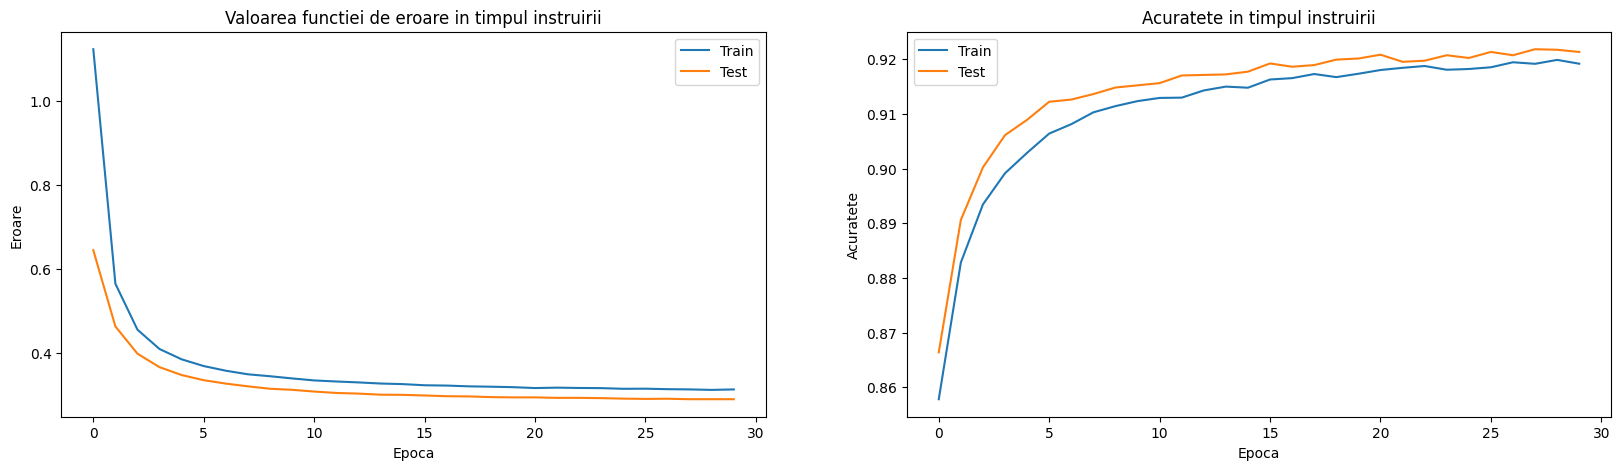

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(train_losses, label='Train')
ax1.plot(test_losses, label='Test')
ax1.set_xlabel('Epoca')
ax1.set_ylabel('Eroare')
ax1.set_title('Valoarea functiei de eroare in timpul instruirii')
ax1.legend()

ax2.plot(train_accuracies, label='Train')
ax2.plot(test_accuracies, label='Test')
ax2.set_xlabel('Epoca')
ax2.set_ylabel('Acuratete')
ax2.set_title('Acuratete in timpul instruirii')
ax2.legend()

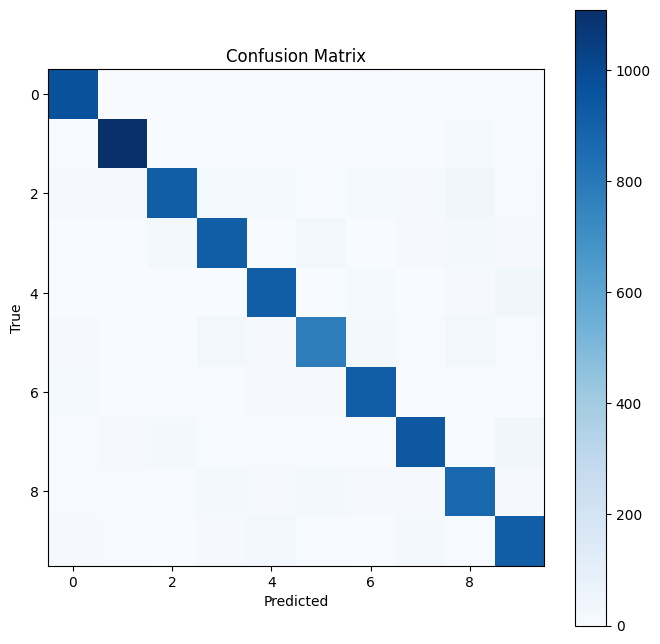

In [23]:
from sklearn.metrics import confusion_matrix

def simple_confusion_matrix(model: nn.Module, test_loader: DataLoader, device: torch.device) -> confusion_matrix:
    model.eval()
    
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            outputs: torch.Tensor = model(x)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    cm: confusion_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm

cm: confusion_matrix = simple_confusion_matrix(model, test_loader, device)